
# Trends disaggregated by vegetation group

Using ESA WorldCover for its simplified classes

In [2]:
%matplotlib inline

import textwrap
import distinctipy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import contextily as ctx
import matplotlib as mpl
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask, round_coords

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Load data

In [3]:
lin_or_circ = 'circular'

#open a simple landcover map
lc = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/ESA_WorldCover_processed.nc').drop_vars('band')

p_average = assign_crs(xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_phenology/results/mean_phenology_perpixel_{lin_or_circ}.nc'), crs='EPSG:4326')
p_trends_orginal = assign_crs(xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_phenology/results/trends_phenology_perpixel_{lin_or_circ}.nc'), crs='EPSG:4326')

mask = ~np.isnan(p_trends_orginal.vPOS_slope)
lc = lc.where(mask)

season_per_year = p_average['n_seasons']/p_average['n_years']
non_seasonal = xr.where((season_per_year <= 0.90),1,0)
extra_seasonal = xr.where((season_per_year >= 1.1),1,0)
seasonality_mask = (non_seasonal | extra_seasonal)

sos_nan = np.isnan(p_trends_orginal['SOS_slope']).where(~np.isnan(p_average['SOS']))
sos_nan = xr.where((sos_nan==1) & (seasonality_mask==0), 1, 0)

eos_nan = np.isnan(p_trends_orginal['EOS_slope']).where(~np.isnan(p_average['EOS']))
eos_nan = xr.where((eos_nan==1) & (seasonality_mask==0), 1, 0)

pos_nan = np.isnan(p_trends_orginal['POS_slope']).where(~np.isnan(p_average['POS']))
pos_nan = xr.where((pos_nan==1) & (seasonality_mask==0), 1, 0)

extra_mask = (seasonality_mask | sos_nan | eos_nan | pos_nan)

## Adjust trend rates by seasons/yr

In [4]:
p_trends_orginal = p_trends_orginal#.where(seasonality_mask!=1)
p_trends = (p_trends_orginal * season_per_year)#.where(seasonality_mask!=1)

In [5]:
# p_trends.TOS_slope.where(p_trends['TOS_p_value'] <= 0.05).plot.imshow(robust=True, cmap='coolwarm', vmin=-2, vmax=2)

### Extract pixels over simple veg classes

In [6]:
lc_names = {
    1:'Trees',
    2:'Shrubs',
    3:'Grasses',
    4:'Sparse',
    5:'Crops'
}

def extract_vars(trends, var, classes_to_extract, lc, nvis_dict):
    dfs = []
    for c in classes_to_extract: #loop through veg classes
        veg_trends = trends.where(lc==c)
        df = veg_trends[[var]].drop_vars('spatial_ref').to_dataframe().rename({var:nvis_dict[c]},axis=1)
        dfs.append(df)
    
    #now append values for entire continent 
    dfs.append(trends[[var]].drop_vars('spatial_ref').to_dataframe().rename({var:'All'},axis=1))

    return pd.concat(dfs).dropna(axis=0, how='all')

simple_classes_to_plot = [1,2,3,5]

NVIS_simple_POS_slopes = extract_vars(p_trends, 'POS_slope', simple_classes_to_plot, lc, lc_names) #.where(extra_mask!=1)
NVIS_simple_vPOS_slopes = extract_vars(p_trends, 'vPOS_slope',simple_classes_to_plot, lc, lc_names)

NVIS_simple_SOS_slopes = extract_vars(p_trends, 'SOS_slope', simple_classes_to_plot, lc, lc_names)
NVIS_simple_vSOS_slopes = extract_vars(p_trends, 'vSOS_slope', simple_classes_to_plot, lc, lc_names)

NVIS_simple_EOS_slopes = extract_vars(p_trends, 'EOS_slope',simple_classes_to_plot, lc, lc_names)
NVIS_simple_vEOS_slopes = extract_vars(p_trends, 'vEOS_slope',simple_classes_to_plot, lc, lc_names)
NVIS_simple_vTOS_slopes = extract_vars(p_trends, 'vTOS_slope',simple_classes_to_plot, lc, lc_names)

NVIS_simple_ROG_slopes = extract_vars(p_trends, 'ROG_slope',simple_classes_to_plot, lc, lc_names)
NVIS_simple_ROS_slopes = extract_vars(p_trends, 'ROS_slope',simple_classes_to_plot, lc, lc_names)

NVIS_simple_AOS_slopes = extract_vars(p_trends, 'AOS_slope',simple_classes_to_plot, lc, lc_names)
NVIS_simple_LOS_slopes = extract_vars(p_trends, 'LOS_slope', simple_classes_to_plot, lc, lc_names)
NVIS_simple_IOS_slopes = extract_vars(p_trends, 'IOS_slope', simple_classes_to_plot, lc, lc_names)
NVIS_simple_IOC_slopes = extract_vars(p_trends, 'IOC_slope', simple_classes_to_plot, lc, lc_names)

### Plot

In [7]:
import matplotlib.patheffects as path_effects

def add_median_labels(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       color='white') #fontweight='bold'
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

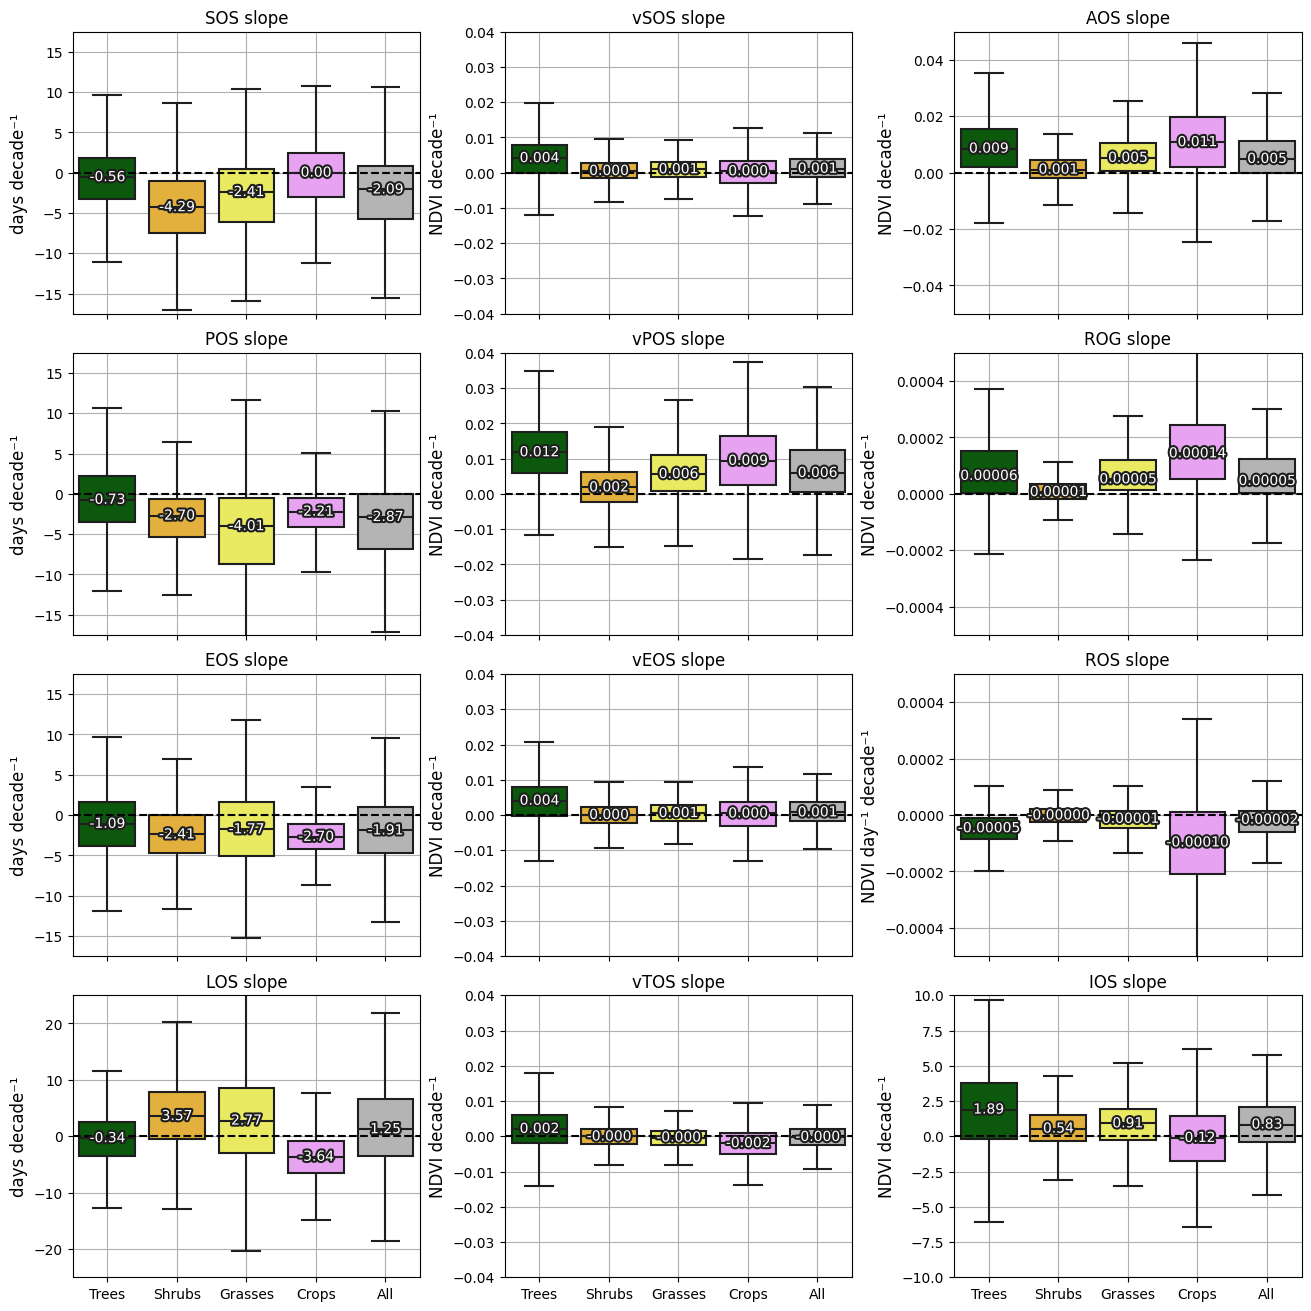

In [8]:
dd = [
    NVIS_simple_SOS_slopes, NVIS_simple_vSOS_slopes, NVIS_simple_AOS_slopes,
    NVIS_simple_POS_slopes, NVIS_simple_vPOS_slopes, NVIS_simple_ROG_slopes,
    NVIS_simple_EOS_slopes, NVIS_simple_vEOS_slopes, NVIS_simple_ROS_slopes,
    NVIS_simple_LOS_slopes, NVIS_simple_vTOS_slopes, NVIS_simple_IOS_slopes
]
names=[
    'SOS slope', 'vSOS slope', 'AOS slope',
    'POS slope', 'vPOS slope', 'ROG slope',
    'EOS slope', 'vEOS slope', 'ROS slope',
    'LOS slope', 'vTOS slope', 'IOS slope',
]

# colors = ['#2E7D32','#4CAF50', 'lightsalmon', '#FFEB3B'] #Forest,Shrub, GRass, crop,
# cmap = LinearSegmentedColormap.from_list("landcover_cmap", colors, N=len(colors))

categories =['tree', 'shrub', 'grass', 'crop', 'all'] # 'sparse', 
colours = ['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#b4b4b4'] # '#b4b4b4',
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')
fig,axes=plt.subplots(4,3, figsize=(13,13), layout='constrained', sharex=True)# sharey='row' # 

for d,n,ax in zip(dd,names,axes.ravel()):
    
    if "v" not in n:
        vmin, vmax=-17.5,17.5
        label='days decade⁻¹'
        fmt = ".2f"
    if "v" in n:
        vmin,vmax=-0.04, 0.04
        label='NDVI decade⁻¹'
        fmt = ".3f"
    if 'LOS' in n:
        vmin, vmax=-25.0, 25.0
        label='days decade⁻¹'
        fmt = ".2f"
    if 'AOS' in n:
        vmin, vmax=-0.05, 0.05
        label='NDVI decade⁻¹'
        fmt = ".3f"
    if 'ROG' in n:
        vmin, vmax=-5e-04, 5e-04
        label='NDVI decade⁻¹'
        fmt = ".5f"
    if 'ROS' in n:
        vmin, vmax=-5e-04, 5e-04
        label='NDVI day⁻¹ decade⁻¹'
        fmt = ".5f"
    if 'IOS' in n:
        vmin, vmax=-10, 10
        label='NDVI decade⁻¹'
        fmt = ".2f"

    sb.boxplot(d*10, ax=ax, palette=colours,linewidth=1.5, showfliers=False) #
    # sb.violinplot(d*10, ax=ax, palette=colours,linewidth=1.5) #
    ax.set_ylim(vmin,vmax)
    ax.axhline(0, c='k', linestyle='--')
    ax.set_title(n)
    ax.set_ylabel(label, fontsize=12)
    ax.grid()
    add_median_labels(ax, fmt=fmt)
    
# fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/Landcover_simple_trends_boxplots.png',
#             bbox_inches='tight', dpi=300) 